In [1]:
from numpy import *; from numpy.core.records import fromarrays;from scipy.constants import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time

def e_ratio(T):
    '''Gives m_e/E, where E=m+T is input in terms of keV'''
    e_mass=m_e*c**2./(kilo*eV)
    return 1./(1.+T/e_mass)

#### Reading in detector response pars

In [2]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)

#### Initializing simulation data

In [4]:
nbins,rang=1000,[0,800]
full_load=True

path='/home/noah/Desktop/large_analysis/zeck_simulation/BSG/'
b0=np.load(path+'b0.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
b1=np.load(path+'b1.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
alpha0,alpha1=np.sum(b0.Ne),np.sum(b1.Ne)


path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
if full_load==True:
    b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')               # Reading in 45Ca b=1 b=0 PENELOPE spectra
    b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)                   # Restructuring the sim data
    b0,b1=b0.view(recarray),b1.view(recarray)                             # Making the spectra record arrays (easier)
    Fullb0,Fullb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)  #Perfect summed simulated spectra
    Fullb0,Fullb1=Fullb0.view(recarray),Fullb1.view(recarray)

else:
    Fullb0,Fullb1=np.load(path+'Fullb0.npy').view(np.recarray),np.load(path+'Fullb1.npy').view(np.recarray)
print(Fullb0.dtype)
Fullb0_hist=histogram(Fullb0.energy,bins=nbins,range=rang)[0]
Fullb1_hist=histogram(Fullb1.energy,bins=nbins,range=rang)[0]
Norm_b0 = 1./np.sum(Fullb0_hist)        # This is used later when taking difference of b=1 and b=0 spectra
Norm_b1 = 1./np.sum(Fullb1_hist)        # This is used later when taking difference of b=1 and b=0 spectra

(numpy.record, [('entry', '<i4'), ('board', '<i4'), ('channel', '<i4'), ('timestamp', '<f4'), ('energy', '<f4')])


#### Making simulated single pixel spectra & Smearing
Note: the smearing is done here. E-->E+deltaE, where deltaE=np.random.normal(loc=0,scale=sigma)

In [5]:
thresh=200                     # in ADC
coinc_window=400e-9
bdchs=[17,41]                            #In this routine, we're removing any events that hit 77W/E
# bdchs=[11]                            #This includes 52,64,65W and 64E
if full_load==True:
    truth0,truth1=np.zeros(len(b0),dtype=bool),np.zeros(len(b1),dtype=bool)
    for bdch in bdchs:                     #Taking sim events ONLY for bdchs
        bd,ch=int(bdch/8),int(bdch%8)
        truth0+=np.logical_not((b0.board==bd)*(b0.channel==ch))
        truth1+=np.logical_not((b1.board==bd)*(b1.channel==ch))
    sb0,sb1=b0[truth0],b1[truth1]
    sb0,sb1=sb0.view(np.recarray),sb1.view(np.recarray)


    bdchs=[6,11,12,35,36]
#     for bdch in bdchs:
#         bd,ch=int(bdch/8),int(bdch%8)
#         sigma=detector_response[bdch]                 # Detector response for bd,ch
#         trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
#         sb0.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))
#         trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb0= with bd ch
#         sb1.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))

    sb0=sb0[sb0.energy>thresh/6.2]                          #Applying threshold cut to sim
    sb1=sb1[sb1.energy>thresh/6.2]                    #Applying threshold cut to sim

    sb0=pd.sim_sing_pix_coinc(sb0,coinc_window) #Summing events within a coinc_window timewindow
    sb0=sb0[pd.sim_single_event(sb0)]           # Making single pixel sim spectra
    sb1=pd.sim_sing_pix_coinc(sb1,coinc_window) #Summing events within a coinc_window timewindow
    sb1=sb1[pd.sim_single_event(sb1)]           # Making single pixel sim spectra
else:
    sb0,sb1=np.load(path+'sb0.npy').view(np.recarray),np.load(path+'sb1.npy').view(np.recarray)

#### Making simulated single pixel histograms

In [6]:
b0_hist,bins=histogram([],bins=nbins,range=rang)   #b0 single pixel histogram
b1_hist,bins=histogram([],bins=nbins,range=rang)   #b1 single pixel histogram
b0_hist,b1_hist=b0_hist.astype(float),b1_hist.astype(float)
bins=pd.cbins(bins)

# bdchs_of_interest=bdchs

bdchs_of_interest=[35]
for bdch in bdchs_of_interest:             # Looping over bdchs to smear sim pixel-by-pixel
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
    b0_hist+=histogram(sb0.energy[trutharray],bins=nbins,range=rang)[0]
    
    trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb1= with bd ch
    b1_hist+=histogram(sb1.energy[trutharray],bins=nbins,range=rang)[0]
print(np.sum(b0_hist),np.sum(b1_hist))
b0_hist*=Norm_b0
b1_hist*=Norm_b1                            # Normalizing the total number of counts in b1 to that of b1
# b0_hist*=1./np.sum(b0_hist)
# b1_hist*=1./np.sum(b1_hist)                            # Normalizing the total number of counts in b1 to that of b1

3388281.0 3266027.0


#### The two smeared spectra are shown below

0.36041474467615947 0.35558884470618485


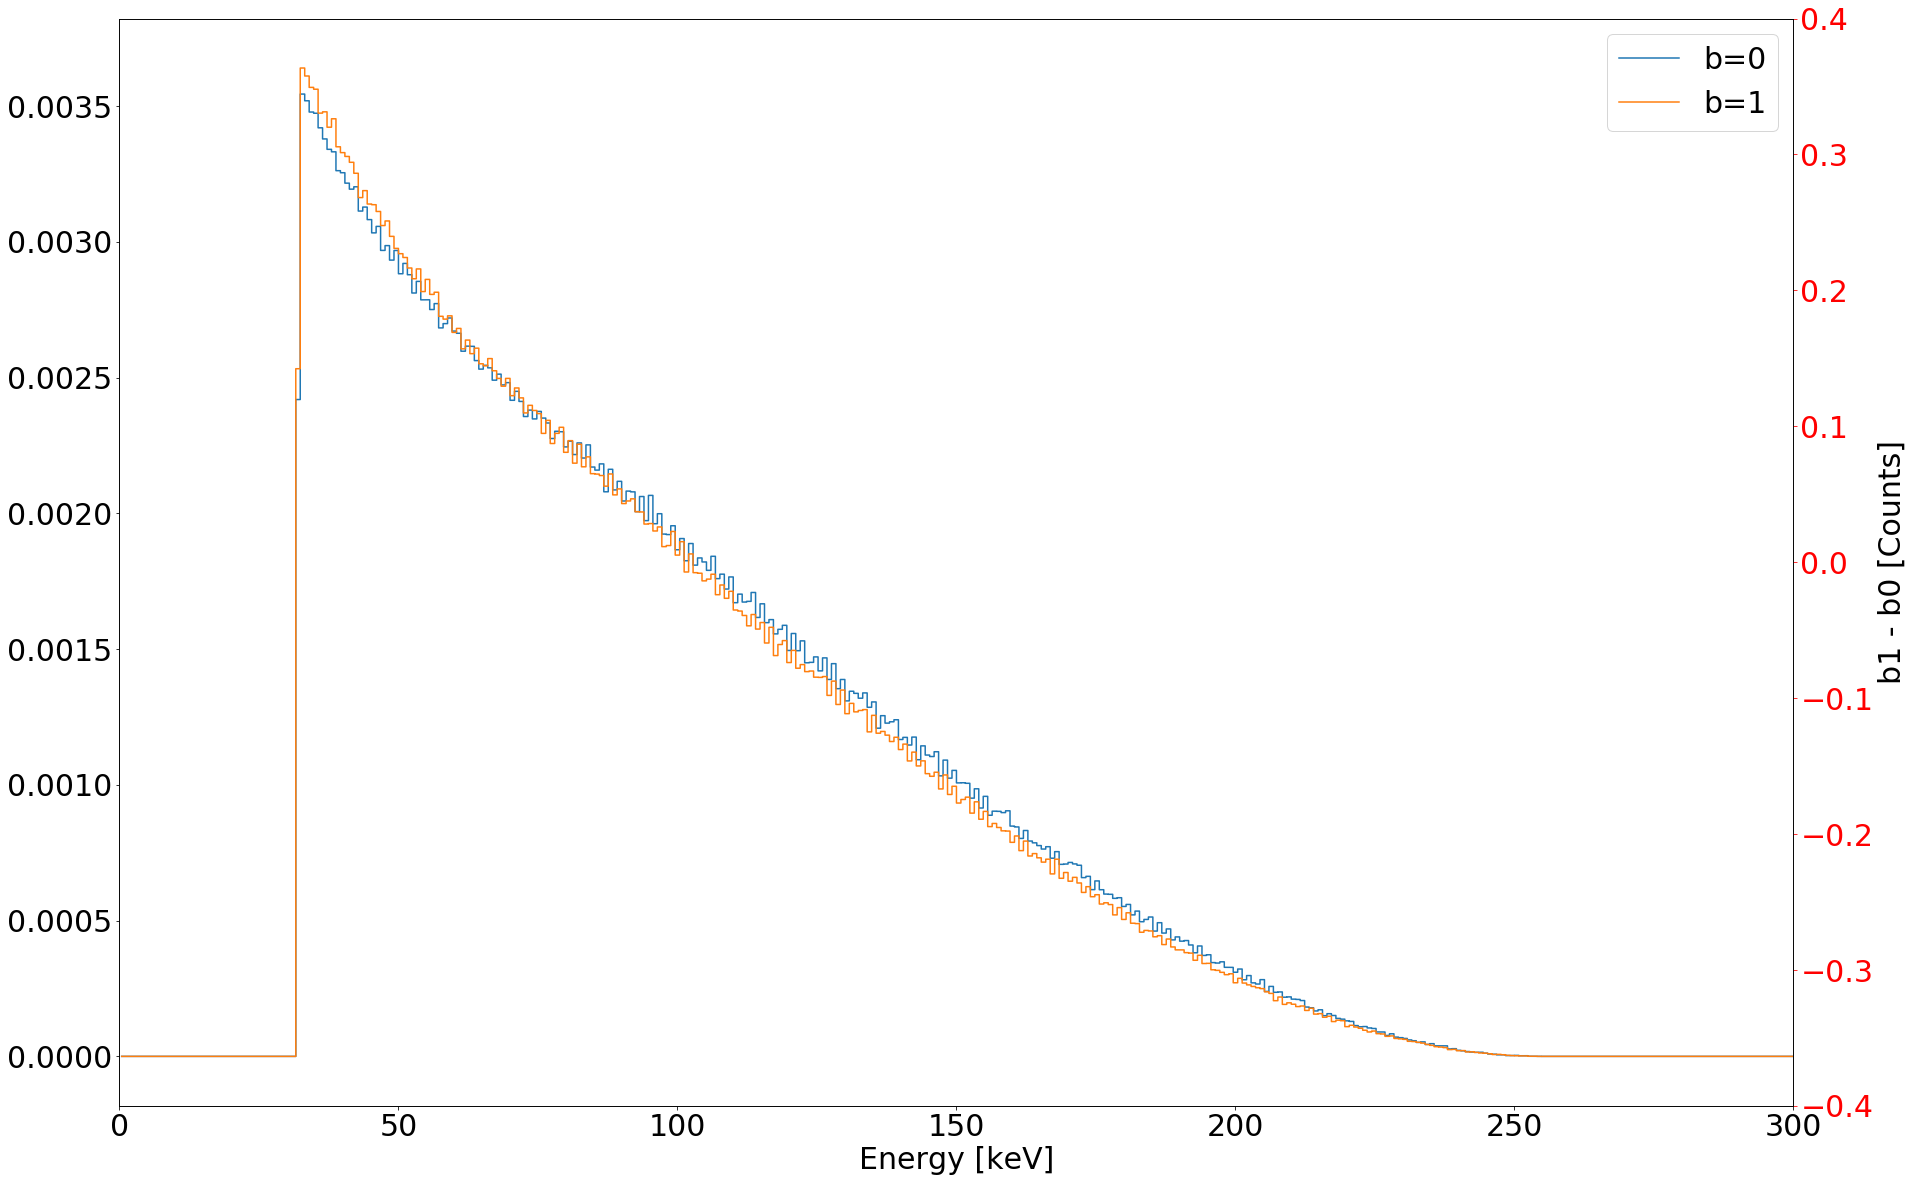

In [7]:
fs=30
fig,ax=subplots(ncols=1,nrows=1,figsize=(30,20))
ax.plot(bins,b0_hist,ds='steps',label='b=0')
ax.plot(bins,b1_hist,ds='steps',label='b=1')
ax.set_xlim(0,300)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.tick_params(labelsize=fs)
ax.legend(fontsize=fs)
ax1=twinx()
t=b0_hist>0
# ax1.plot(bins[t],(b1_hist[t]-b0_hist[t])/b0_hist[t],c='r',ds='steps')
ax1.tick_params('y', labelsize=fs,colors='r')
ax1.set_ylabel('b1 - b0 [Counts]',fontsize=fs)
ax1.set_ylim(-0.4,0.4)
print(np.sum(b0_hist),np.sum(b1_hist))
show();


---
---
#### Now loading all 45Ca data

In [8]:
tr=200

d=load(path+'sb1.npy')        # Edit this once combine_all...ipynb finishes This file has all runs stored in it

        ### GOTTA CALIBRATE!!!!!!
d=d.view(recarray)

t=np.zeros(len(d),dtype=bool)
for bdch in bdchs_of_interest:
    bd,ch=int(bdch/8),int(bdch%8)
    t+=(d.board==bd)*(d.channel==ch)
d=d[t]   

osc_amp = 50                            # All WF with an oscillation amp less than osc_amp are included
# trutharray = np.sqrt(np.sum(d.osc_amps[:,0:2]**2.,axis=1)) < osc_amp  #OSCILLATION CUT
# d=d[trutharray]
d_hist=histogram(d.energy,bins=nbins,range=rang)[0]
print(np.sum(d_hist))

3266608


#### Fitting simulation to data
$$N\left(w(b=0)+b\left[w(b=1)-w(b=0)\right]\right)$$

Sliding window (constant fit length)

[35]
[0.52797564]


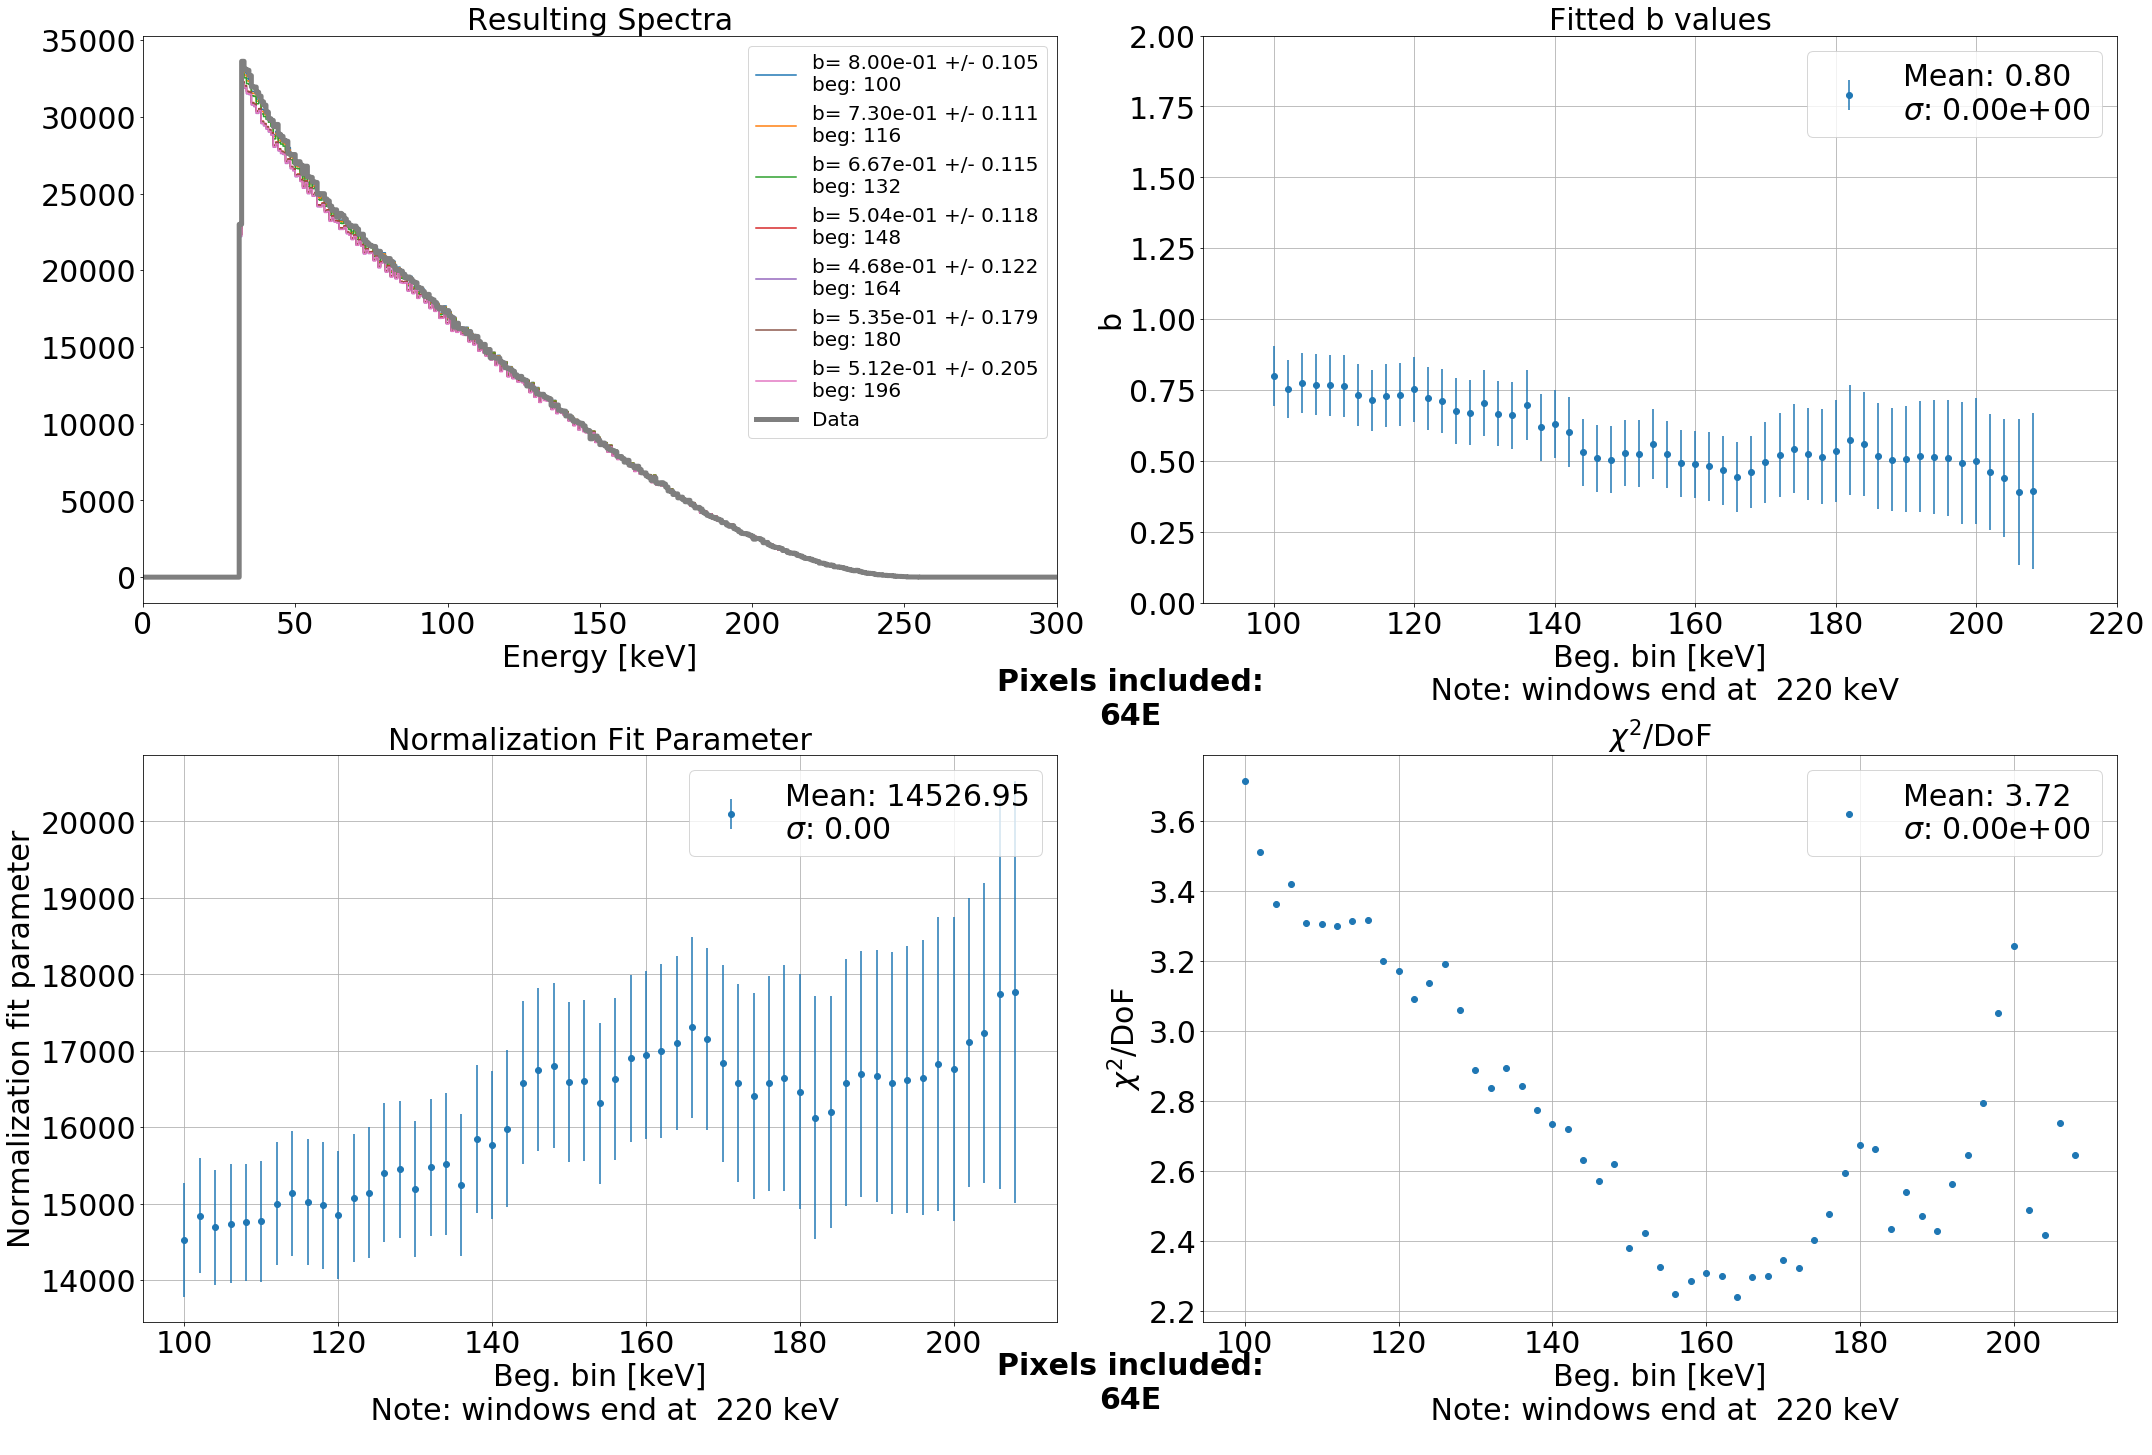

In [9]:
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
if 35 in bdchs_of_interest:
    steps=arange(100,end-10,2)
else:
    steps=arange(40,end-10,2)
true_bs=[]
true_b_err=[]
print(bdchs_of_interest)
if 11 in bdchs_of_interest:
    beg_bad,end_bad=120,180
else:
    beg_bad,end_bad=100,100

# for beg in [steps[0]]:
for beg in steps:
#     end=beg+stepsize                 # 20 keV length == 25 points to fit to
#     if beg_bad<beg<
    if beg > end_bad:
        trutharray = ((bins>beg)*(bins<end))  # Trutharray for fit window
    else:
        trutharray = ((bins>beg)*(bins<beg_bad))+((bins>end_bad)*(bins<end))  # Trutharray for fit window
    rel_uncert_data=sqrt(d_hist[trutharray]);rel_uncert_data[rel_uncert_data==0]=1
    rel_uncert_sim=sqrt(b0_hist[trutharray]);rel_uncert_sim[rel_uncert_sim==0]=1
    rel_uncert_data=1./rel_uncert_data; rel_uncert_sim=1./rel_uncert_sim
#     weights=sqrt(rel_uncert_data**2.+rel_uncert_sim**2.)*sqrt(d_hist[trutharray])
#     weights=sqrt(d_hist[trutharray])  # Statistical weights (erros) only
    weights=np.sqrt(d_hist[trutharray])
#     weights=sqrt(rel_uncert_data**2.+rel_uncert_sim**2.)*sqrt(d_hist[trutharray])

    X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit
    
    pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                      p0=[d_hist[trutharray][0],0],sigma=weights,\
                       absolute_sigma=False,maxfev=1000000,ftol=1e-10)
#                       epsfcn=1e-9)

    vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors

    chisq=np.sum((d_hist[trutharray]-pd.fierz_fit(X,*pars))**2./d_hist[trutharray])/(np.sum(trutharray)-len(pars))
    out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
    b_vals=vstack((b_vals,out))

names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats
#np.save('b_vals-T_'+str(thresh),b_vals)
fs=30
fig,ax=subplots(nrows=2,ncols=2,figsize=(30,20))

for i in range(len(b_vals)):
    vals=b_vals[i]
    X=(np.ones(len(bins),dtype=bool),alpha0*b0_hist,alpha1*b1_hist)
#     if i%3==0:
    if vals.beg >0 and i%8==0:
        ax[0,0].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))
        
# for i in range(len(b_vals)):
#     vals=b_vals[i]
#     X=(np.ones(len(bins),dtype=bool),b0_hist,b1_hist)
#     if i%3==0:
#     if vals.beg <110 and i%4==0:
#         ax[1,1].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))        
text='Pixels included:\n'
for bdch in bdchs_of_interest:
    bd=int(bdch/8);ch=int(bdch%8)
    text+=pd.pixel(bd,ch)+'\n'
trutharray=b_vals.beg<=100
ax[0,0].plot(bins,d_hist,ds='steps',label='Data',lw=5)        
ax[0,0].legend(fontsize=fs-10)
ax[0,0].set_xlim(0,300)
ax[0,0].tick_params(labelsize=fs)
ax[0,0].set_title('Resulting Spectra',fontsize=fs)
ax[0,0].set_xlabel('Energy [keV]',fontsize=fs)
# ax[0,0].set_yscale('log')
ax[0,1].errorbar(b_vals.beg,b_vals.b,b_vals.b_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.b[trutharray].mean())+': {:0.2e}'.format(b_vals.b[trutharray].std()))
# ax[0,1].errorbar(b_vals.beg,true_bs,true_b_err,fmt='o',\
#                  label='Mean: {:0.2f}\n'r'$\sigma$'.format(true_bs[trutharray].mean())+': {:0.2f}'.format(true_bs[trutharray].std()))
ax[0,1].legend(fontsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[0,1].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[0,1].set_xticks(arange(40,300,20))
ax[0,1].grid()
ax[0,1].set_ylabel('b',fontsize=fs)
ax[0,1].set_title('Fitted b values',fontsize=fs)
ax[0,1].set_ylim(0,2)
ax[0,1].set_xlim(90,220)
ax[1,0].errorbar(b_vals.beg,b_vals.N,b_vals.N_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.N[trutharray].mean())+': {:0.2f}'.format(b_vals.N[trutharray].std()))
ax[1,0].legend(fontsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[1,0].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[1,0].set_ylabel('Normalization fit parameter',fontsize=fs)
ax[1,0].set_title('Normalization Fit Parameter',fontsize=fs)
ax[1,0].grid()
ax[1,1].plot(b_vals.beg,b_vals.chisq,marker='o',ls='None',\
             label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.chisq[trutharray].mean())+': {:0.2e}'.format(b_vals.chisq[trutharray].std()))
ax[1,1].legend(fontsize=fs)
ax[1,1].tick_params(labelsize=fs)
ax[1,1].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[1,1].set_ylabel(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].set_title(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].grid()
for i in range(1,4):
    row=int(i/2);col=int(i%2)
#     ax[row,col].set_xlim(150,300)
fig.text(0.525,0.5,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')

fig.text(0.525,0.025,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
# ax[1].set_ylim(-2,2)
tight_layout()
print(b_vals.b[steps==150])
show()

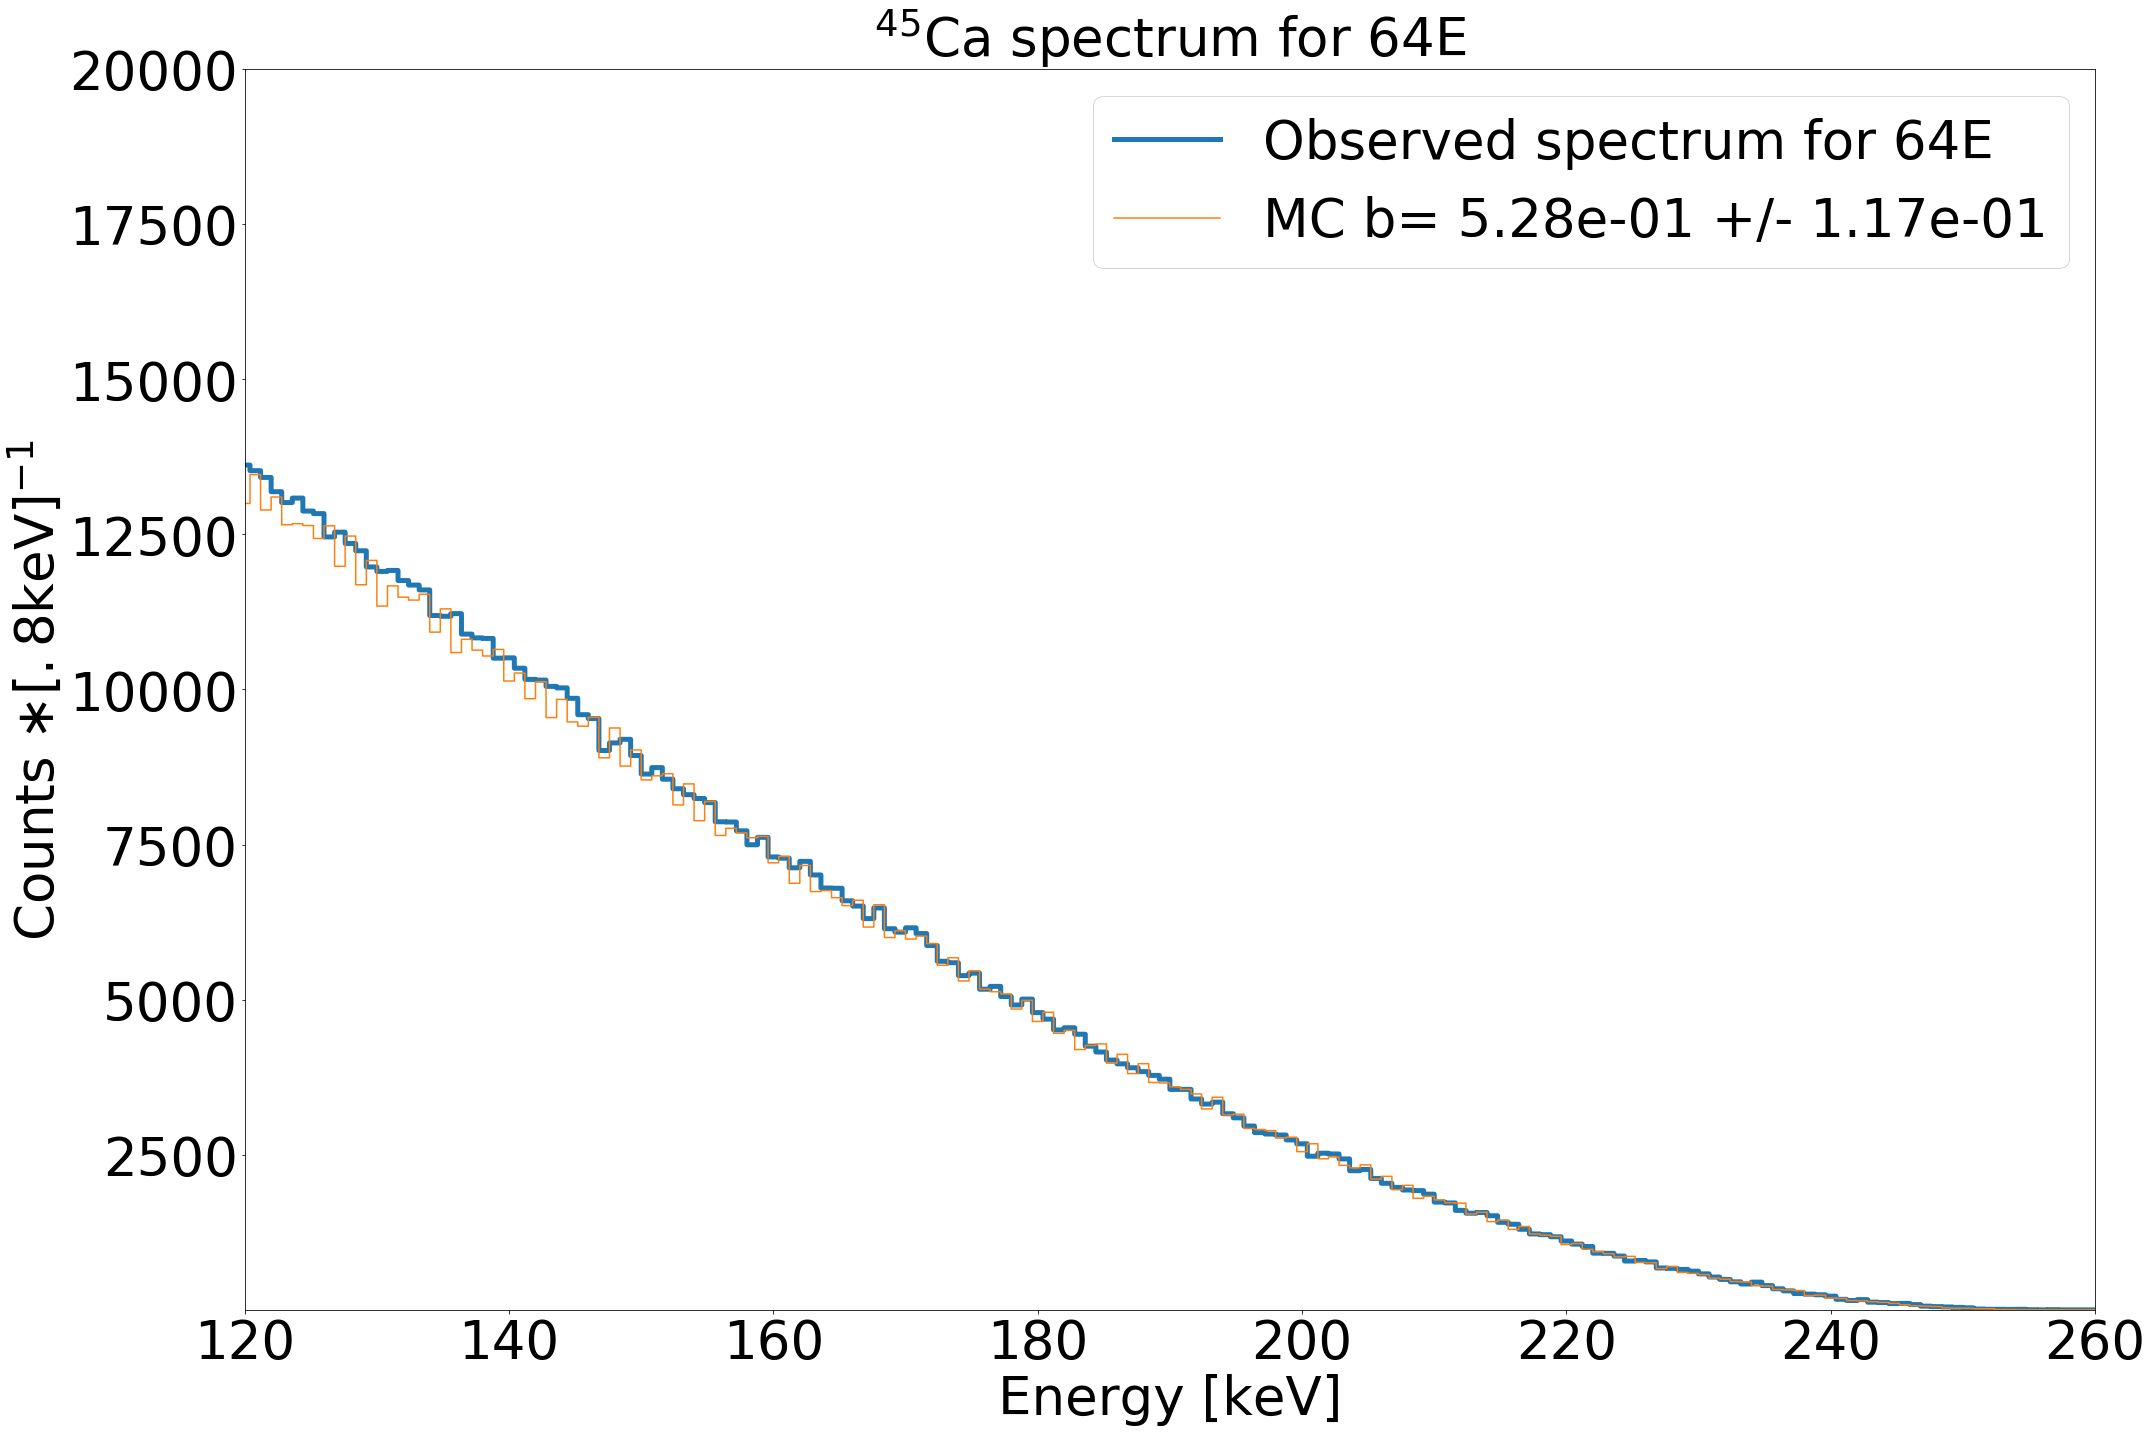

In [10]:
fs=53
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
if 35 in bdchs_of_interest:
    steps=arange(100,end-10,2)
else:
    steps=arange(40,end-10,2)
true_bs=[]
true_b_err=[]

beg,end=150,220
trutharray=(bins>beg)*(bins<end)
weights=np.sqrt(d_hist[trutharray])
#     weights=sqrt(rel_uncert_data**2.+rel_uncert_sim**2.)*sqrt(d_hist[trutharray])

X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit
    
pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                  p0=[d_hist[trutharray][0],0],sigma=weights,\
                   absolute_sigma=False,maxfev=1000000,ftol=1e-8)
#                       epsfcn=1e-9)

vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors
fig,ax=subplots(figsize=(30,20))
ax.plot(bins,d_hist,ds='steps',label='Observed spectrum for '+pd.pixel(bd,ch),lw=5)
X=(np.ones(len(bins),dtype=bool),alpha0*b0_hist,alpha1*b1_hist)
ax.plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='MC b= {:0.2e} +/- {:0.2e}'.format(pars[1],vrs[1]))
ax.legend(fontsize=fs)
ax.set_xlim(0,300)
ax.tick_params(labelsize=fs)
ax.set_ylabel(r'Counts $\ast [.8 \mathrm{keV}]^{-1}$',fontsize=fs)
ax.set_title(r'$^{45}\mathrm{Ca}$ spectrum for '+pd.pixel(bd,ch),fontsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_xlim(120,260)
ax.set_ylim(1,2e4)
fig.tight_layout()
# savefig('/home/noah/Desktop/phd/ut-thesis/figures/pdf/calcium_spectrum-'+pd.pixel(bd,ch)+'.pdf',format='pdf')
show()